In [1]:
import RPNTask
import tree_loaders

# Introducing `PCFGDataset`

Given a PCFG specified as an `nltk.PCFG` object, we can create a dataset that will draw example trees from that grammar. The following dataset generates arithmetic expressions in Polish notation. The derivations are annotated with the desired transformation type -- the first production is `POLISH` if we want to instruct our seq2seq model to apply the identity transformation, and `RPN` if we want to convert the expression to Reverse Polish Notation

In [2]:
print(RPNTask.polish_annotated)

Grammar with 20 productions (start state = START)
    START -> POLISH [0.5]
    START -> RPN [0.5]
    POLISH -> EXPR [1.0]
    RPN -> EXPR [1.0]
    EXPR -> OPERAND [0.6]
    EXPR -> OPERATOR EXPR EXPR [0.4]
    OPERATOR -> '+' [0.25]
    OPERATOR -> '-' [0.25]
    OPERATOR -> '*' [0.25]
    OPERATOR -> '/' [0.25]
    OPERAND -> VARIABLE [0.5]
    OPERAND -> NUMBER [0.5]
    VARIABLE -> 'a' [0.25]
    VARIABLE -> 'b' [0.25]
    VARIABLE -> 'x' [0.25]
    VARIABLE -> 'y' [0.25]
    NUMBER -> '2' [0.25]
    NUMBER -> '3' [0.25]
    NUMBER -> '4' [0.25]
    NUMBER -> '5' [0.25]


The following code creates a dataset object from this grammar. The remaining arguments specify that it should contain `100` trees drawn randomly using the random seed `42`. The productions are constrained to have a minimum sequence length of `5` and a maximum length of `15`. When we create a torchtext dataset, we have to specify a list of fields. For now we will include just two: the first just outputs the tree as an `nltk.Tree`, with some optional light preprocessing -- this is the `TreeField` type. In this case, we collapse unitary productions, so that `EXPR => OPERAND => NUMBER => 5` becomes a single production `EXPR+OPERAND+NUMBER => 5`. The second field is a `TreeSequenceField`, which reads a tree and flattens it into a sequence. We pass the first field `SRC` as an argument so that `SRC_SEQ` knows to apply the same preprocessing steps on the tree before flattening it. The `TreeSequenceField` is a subclass of the standard torchtext `Field` class, and takes all the same optional arugments (like `lower`, which converts the words to lower case). 

In [3]:
SRC = tree_loaders.TreeField(collapse_unary=True)
SRC_SEQ = tree_loaders.TreeSequenceField(SRC, lower=True)

fields = {"source_tree": SRC, "source_seq": SRC_SEQ}

dataset = tree_loaders.PCFGDataset(RPNTask.polish_annotated, 100, fields, min_length=5, max_length=15, seed=42)

We can index `dataset` like a list -- each element is a torchtext `Example` class with the two fields we specified: `source_tree` and `source_seq`.

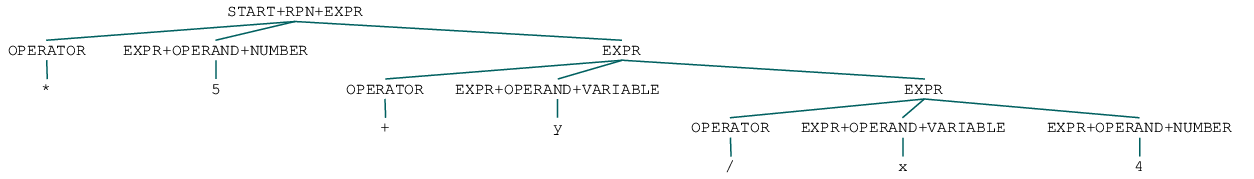

In [4]:
dataset[0].source_tree

In [5]:
dataset[0].source_seq

['*', '5', '+', 'y', '/', 'x', '4']

# More Fields
Now we'll try out some different field types. We'll include a different kind of field class, the `TreeExtractor`, to extract the transformation annotation -- either `POLISH` or `RPN`. `TreeExtractor` is a subclass of `TreeField`, and so we can provide the same set of arguments. We don't want to `collapse_unary` since then the annotation would get combined with other non-terminal labels. Furthermore, we provide a custom tree transformation function to get rid of the start tag of the tree. After this preprocessing step, the root node will be `POLISH` or `RPN` -- exactly what we are looking for. 

In addition to the `SEQ` field from earlier, we provide another `TreeExtractorField` that applies a transformation to the tree. The transformation is defined below. If the tree is annotated with `RPN`, it turns converts Polish notation to Reverse Polish Notation, otherwise it does nothing. Lastly, we provide a `TreeSequenceField` that turns this transformed tree into a flat sequence. This time, we specify `inner_order="pre"` and `inner_symbol="NULL"`. These arguments specify how to decorate the sequence to capture the structure of the tree. Rather than just listing the leaves of the tree as before, we perform a depth-first search but replace the labels of inner nodes with the word `"NULL"`. (Since we also specify `lower=True`, this will get converted to `"null"`).

In [6]:
def my_transform(t):
    if t[0].label() == "RPN":
        return RPNTask.polish2reversePolish(t)
    elif t[0].label() == "POLISH":
        return t
    else:
        assert False, "tree not annotated as expected"

In [7]:
EXTRACT = tree_loaders.TreeExtractorField(tree_transformation_fun=lambda t: t[0], collapse_unary=False)
TAR = tree_loaders.TreeField(my_transform, collapse_unary=True)
TAR_SEQ = tree_loaders.TreeSequenceField(TAR, inner_order="pre", inner_symbol="NULL", lower=True)

fields2 = {"source_tree": SRC, "source_seq": SRC_SEQ, "annotation": EXTRACT, 
           "target_tree": TAR, "target_seq": TAR_SEQ}

dataset2 = tree_loaders.PCFGDataset(RPNTask.polish_annotated, 100, fields2, min_length=5, max_length=15, seed=42)


Let's confirm that the fields of the dataset came out as hoped. Notice that because we set the random seed, the same tree is produced as before.

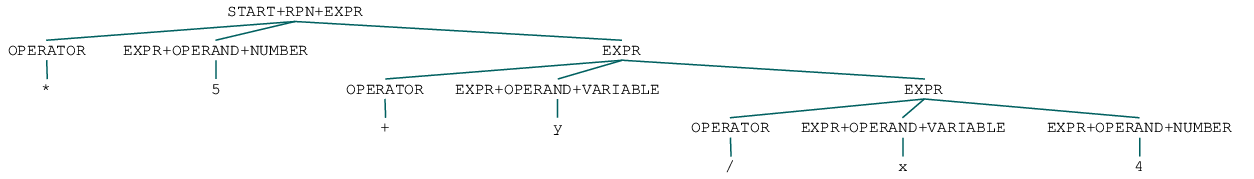

In [8]:
dataset2[0].source_tree

In [9]:
dataset2[0].source_seq

['*', '5', '+', 'y', '/', 'x', '4']

In [10]:
dataset2[0].annotation

'RPN'

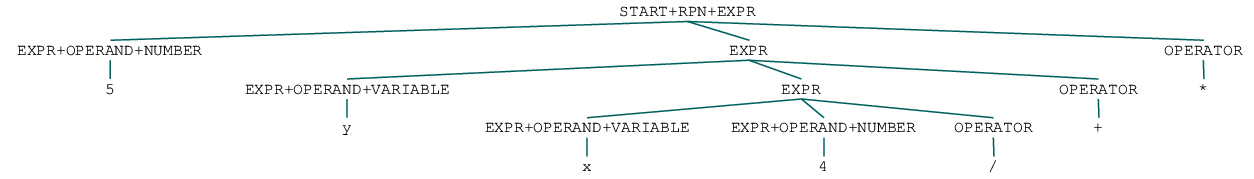

In [11]:
dataset2[0].target_tree

In [12]:
dataset2[0].target_seq

['null', '5', 'null', 'y', 'null', 'x', '4', '/', '+', '*']

In this example, the annotation is `RPN`. Let's check that if the annotation is `POLISH`, no transformation is applied:

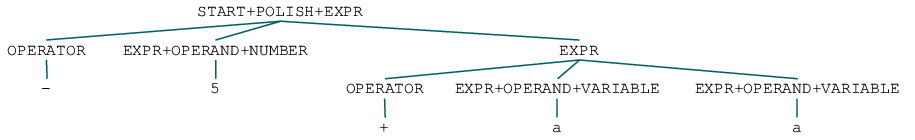

In [13]:
dataset2[5].source_tree

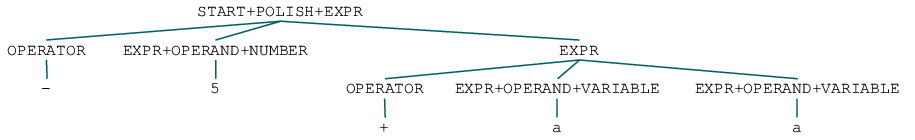

In [14]:
dataset2[5].target_tree

# Saving Datasets to files
We can save a dataset using the function `write_dataset`. Each example in the dataset becomes a line in the file, and each line contains a tab-separated list of the example's fields' values. In this case, we will save three fields: the source tree, the annotation, and the target tree. The source and target tree fields are tree objects, so they will be converted to strings by using the built-in `str` function (and replacing all tabs and newlines with single spaces). This function works for all kinds of torchtext datsets, not just `PCFGDatasets`.

In [36]:
fields3 = {"source_tree": SRC, "annotation": EXTRACT, "target_tree": TAR}

dataset3 = tree_loaders.PCFGDataset(RPNTask.polish_annotated, 20, fields3, min_length=5, max_length=15, seed=42)

tree_loaders.write_dataset(dataset3, "demo_savefile.txt")

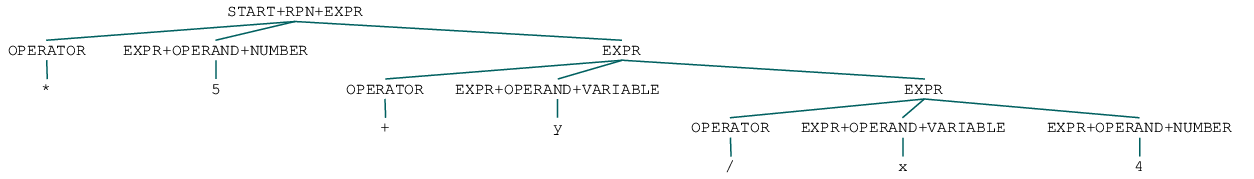

In [37]:
dataset3[0].source_tree

As expected, the first line of `demo_savefile.txt` is:

`(START+RPN+EXPR   (OPERATOR *)   (EXPR+OPERAND+NUMBER 5)   (EXPR     (OPERATOR +)     (EXPR+OPERAND+VARIABLE y)     (EXPR       (OPERATOR /)       (EXPR+OPERAND+VARIABLE x)       (EXPR+OPERAND+NUMBER 4))))	RPN	(START+RPN+EXPR   (EXPR+OPERAND+NUMBER 5)   (EXPR     (EXPR+OPERAND+VARIABLE y)     (EXPR       (EXPR+OPERAND+VARIABLE x)       (EXPR+OPERAND+NUMBER 4)       (OPERATOR /))     (OPERATOR +))   (OPERATOR *))`

(Here the RPN tag is surrounded by tabs, and all the other whitespace is just spaces).

# Loading Datasets from file
We can use the standard torchtext class `TabularDataset` to read a dataset from `tsv`. In this case, the text we want to read is a string representation of a tree. We can use the `TreeField` class to automatically parse this format. We specify `read_nonterminals=True` to tell the parser that the non-terminals are included (`(EXPR (OPERATOR +) ...)` rather than `((+) ...)`). We also tell the parser to look for parentheses rather than square brackets. This same tree reader field can be used to read both the source tree column and the target tree column since neither requires any more preprocessing. A simple torchtext `Field` object suffices to read in the annotation tag. Finally, notice that we specify the fields with a list of tuples rather than a dictionary. Order matters, since we have to match the order of the columns in the file we are reading:

In [38]:
from torchtext.data import TabularDataset, Field

TREE_READ = tree_loaders.TreeField(read_heads=True, brackets="()")
ANNOT = Field()


fields4 = [("source_tree", TREE_READ), ("annotation", ANNOT), ("target_tree", TREE_READ)]
dataset4 = TabularDataset("demo_savefile.txt", "tsv", fields=fields4,)

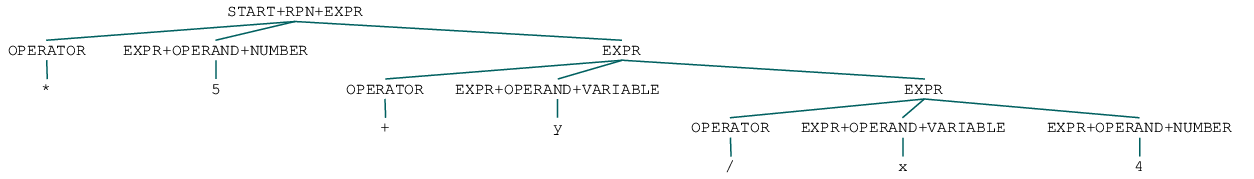

In [39]:
dataset4[0].source_tree

In [40]:
dataset4[0].annotation

['RPN']

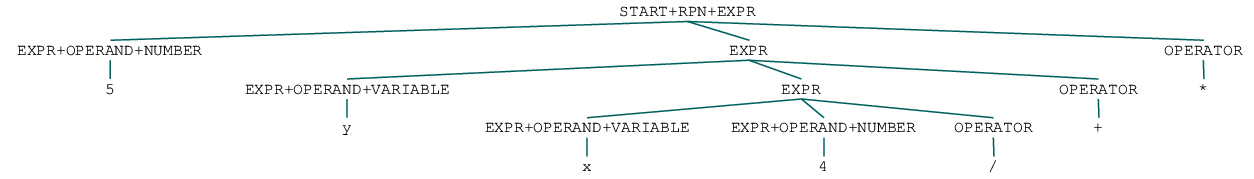

In [41]:
dataset4[0].target_tree

# Reading multiple fields from a single column
The above example works as expected, but doesn't really produce the dataset that we need. We want to have fields for the input and output sequences too, like we had before! To do this, we have to read two fields from the input tree column, and two fields from the output tree column. We can specify this using the expression below:

In [46]:
INSEQ = tree_loaders.TreeSequenceField(TREE_READ, lower=True)
OUTSEQ = tree_loaders.TreeSequenceField(TREE_READ, inner_order="pre", inner_symbol="NULL")

fields5 = [(("source_tree", "source_seq"), (TREE_READ, INSEQ)), 
           ("annotation", ANNOT), 
           (("target_tree", "target_seq"), (TREE_READ, OUTSEQ))]
dataset5 = TabularDataset("demo_savefile.txt", "tsv", fields=fields5)

In [44]:
dataset5[0].source_seq

['*', '5', '+', 'y', '/', 'x', '4']

In [47]:
dataset5[0].target_seq

['NULL', '5', 'NULL', 'y', 'NULL', 'x', '4', '/', '+', '*']